# Targeted Bisuflite Sequencing Alignment Quality 
- Parse the BSBolt log files to get general alignment statistics 
- Run *samtools flagstat* on the bam files with marked duplicates
    - Estimate duplication rate for each sample 
    - Samtools flagstat is called externally using python built-in library *subprocess* 
    - Command is run in parallel using *joblib*, a third party multiprocessing library that forms the backend for many projects like *sklearn*
- Plot the resulting QC checks using *matplotlib* and *seaborn* libraries

In [1]:
# import libraries
import os
import subprocess

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from tqdm.notebook import tqdm

In [2]:
# use latex formatting for figures, latex must be on system path for this to work 
rc('text', usetex=False)

# set environment plotting params
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [3]:
# set working directory
wd = '~/working_directory/'

In [4]:
samples = []
with open('samples.txt', 'r') as sample_list:
    for sample in sample_list:
        samples.append(sample.strip())

## Parse BSBolt Alignment logs

In [13]:
def parse_log(log_file):
    alignment_log = {}
    if not os.path.exists(log_file):
        return log_file.split('/')[-1], alignment_log
    # open log file as plain text file 
    with open(log_file, 'r') as log:
        for line in log:
            if 'Alignment Complete: Time ' in line:
                alignment_time = line.replace('Alignment Complete: Time ', '').strip().split(':')
                alignment_seconds = int(alignment_time[0]) * 60 * 60 + int(alignment_time[1]) * 60 + int(alignment_time[2])
                alignment_log['AlignmentTimeSec'] = alignment_seconds
            elif 'Total Reads: ' in line:
                alignment_log['TotalReads'] = int(line.replace('Total Reads: ', '').strip())
            elif 'Mappability' in line:
                alignment_log['Mappability'] = float(line.replace('Mappability: ', '').replace('%', '').strip())
            elif 'Watson_C2T' in line:
                alignment_log['WatsonC2T'] = int(line.split(':')[1].strip())
            elif 'Watson_G2A' in line:
                alignment_log['WatsonG2A'] = int(line.split(':')[1].strip())
            elif 'Crick_C2T' in line:
                alignment_log['CrickC2T'] = int(line.split(':')[1].strip())
            elif 'Crick_G2A' in line:
                alignment_log['CrickG2A'] = int(line.split(':')[1].strip())
            elif 'Unmapped' in line:
                alignment_log['Unmapped'] = int(line.split(':')[1].strip())
            elif 'Ambiguous' in line:
                alignment_log['BSAmbiguous'] = int(line.split(':')[1].strip())
    return log_file.split('/')[-1], alignment_log

In [14]:
# parse all logs and save data in dict

sample_stats = {}

for sample in tqdm(samples):
    _, log = parse_log(f'{wd}alignments/{sample}.log')
    sample_stats[sample] = log

In [15]:
# transform dict into pandas dataframe and plot
stats_df = pd.DataFrame(sample_stats).T

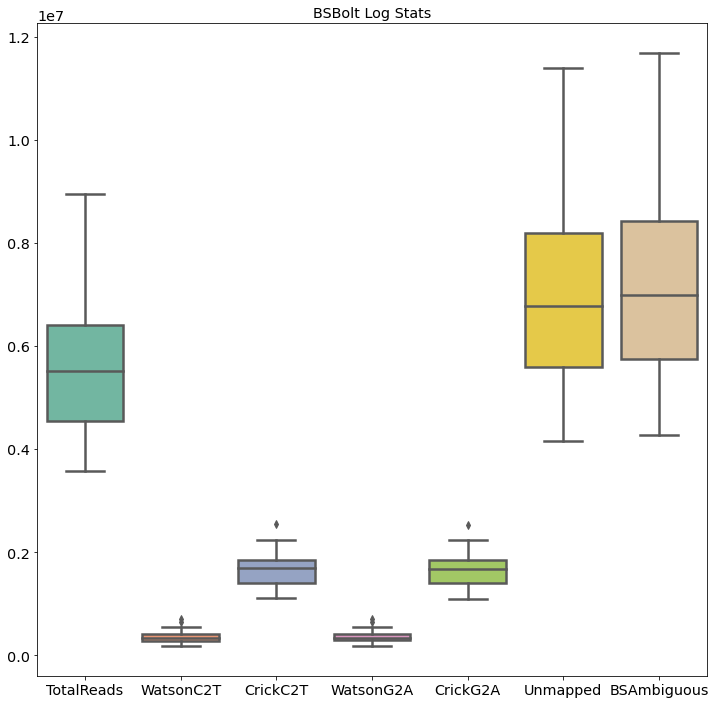

In [28]:
fig, ax = plt.subplots(figsize=(12,12))

plot_cats = ['TotalReads','WatsonC2T','CrickC2T','WatsonG2A','CrickG2A','Unmapped','BSAmbiguous']
sns.boxplot(data=stats_df[plot_cats], ax=ax, palette='Set2', linewidth=2.5)
ax.set_title('BSBolt Log Stats')
#plt.savefig('bsb_log_stats.png', dpi=200, bbox_inches='tight')
plt.show()

In [17]:
# run samtools flagstat on each sample and parse output 
# command will fail if samtools is not on path
def get_flagstats(sample_path, sample_name):
    sam_stats = {}
    sam_args = ['samtools', 'flagstat', sample_path]
    with subprocess.Popen(args=sam_args, stdout=subprocess.PIPE, universal_newlines=True) as sam_process:
        for count, line in enumerate(iter(sam_process.stdout)):
            if count == 0:
                sam_stats['TotalReads'] = int(line.split(' ')[0])
            elif count == 1:
                sam_stats['SecondaryAlignment'] = int(line.split(' ')[0])
            elif count == 2:
                sam_stats['Supplementary']= int(line.split(' ')[0])
            elif count == 3:
                sam_stats['Duplicate']= int(line.split(' ')[0])
            elif count == 4:
                sam_stats['Mapped']= int(line.split(' ')[0])
            elif count == 5:
                sam_stats['Paired']= int(line.split(' ')[0])
            elif count == 6:
                sam_stats['Read1']= int(line.split(' ')[0])
            elif count == 7:
                sam_stats['Read2']= int(line.split(' ')[0])
            elif count == 8:
                sam_stats['ProperPair']= int(line.split(' ')[0])
            elif count == 9:
                sam_stats['MateMapped']= int(line.split(' ')[0])
            elif count == 10:
                sam_stats['Singletons']= int(line.split(' ')[0])
            elif count == 11:
                sam_stats['MateMappedToDiffChrom']= int(line.split(' ')[0])
            elif count == 12:
                sam_stats['MateMappedToDiffChromMapq>=5']= int(line.split(' ')[0])
    return sample_name, sam_stats

In [18]:
# use multiple processing threads to parallelize
flag_stats = joblib.Parallel(n_jobs=14, verbose=10)(joblib.delayed(get_flagstats)(*[f'{wd}alignments/{sample}.dup.bam', sample]) for sample in samples)

[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   4 tasks      | elapsed:  1.8min
[Parallel(n_jobs=14)]: Done  13 tasks      | elapsed:  2.3min
[Parallel(n_jobs=14)]: Done  26 out of  48 | elapsed:  3.8min remaining:  3.2min
[Parallel(n_jobs=14)]: Done  31 out of  48 | elapsed:  4.9min remaining:  2.7min
[Parallel(n_jobs=14)]: Done  36 out of  48 | elapsed:  5.2min remaining:  1.7min
[Parallel(n_jobs=14)]: Done  41 out of  48 | elapsed:  5.7min remaining:   58.3s
[Parallel(n_jobs=14)]: Done  46 out of  48 | elapsed:  6.0min remaining:   15.6s
[Parallel(n_jobs=14)]: Done  48 out of  48 | elapsed:  6.0min finished


In [19]:
# format flagstat results

processed_flag_stats = {}

for sample, f_stats in flag_stats:
    processed_flag_stats[sample] = f_stats

In [21]:
# make pandas data frame 
flag_df = pd.DataFrame(processed_flag_stats).T

In [22]:
# add duplication rate statistic
flag_df['DuplicationRate'] = flag_df['Duplicate'] / flag_df['Mapped'] 

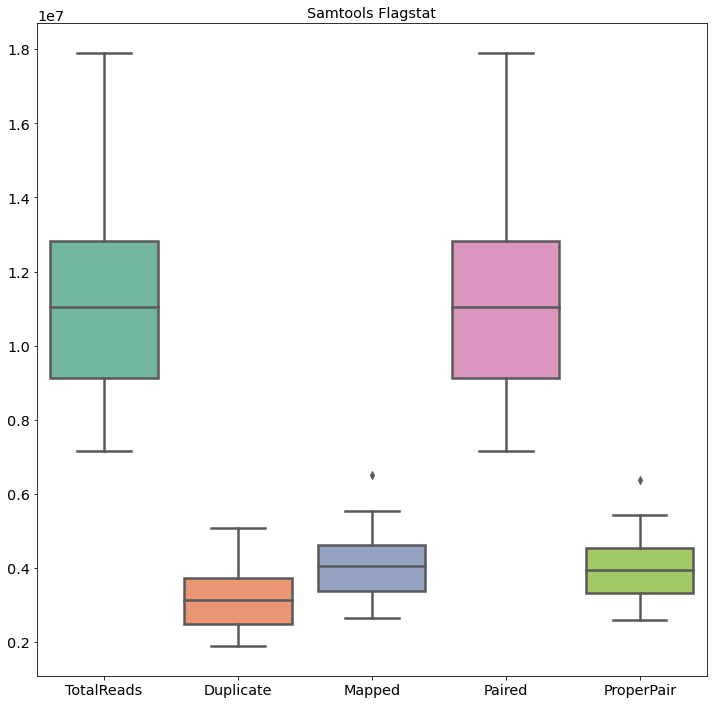

In [29]:
fig, ax = plt.subplots(figsize=(12,12))

plot_cats = ['TotalReads', 'Duplicate', 'Mapped', 'Paired', 'ProperPair']
sns.boxplot(data=flag_df[plot_cats], ax=ax, palette='Set2', linewidth=2.5)
ax.set_title('Samtools Flagstat')
#plt.savefig('flagstats.png', dpi=200, bbox_inches='tight')
plt.show()

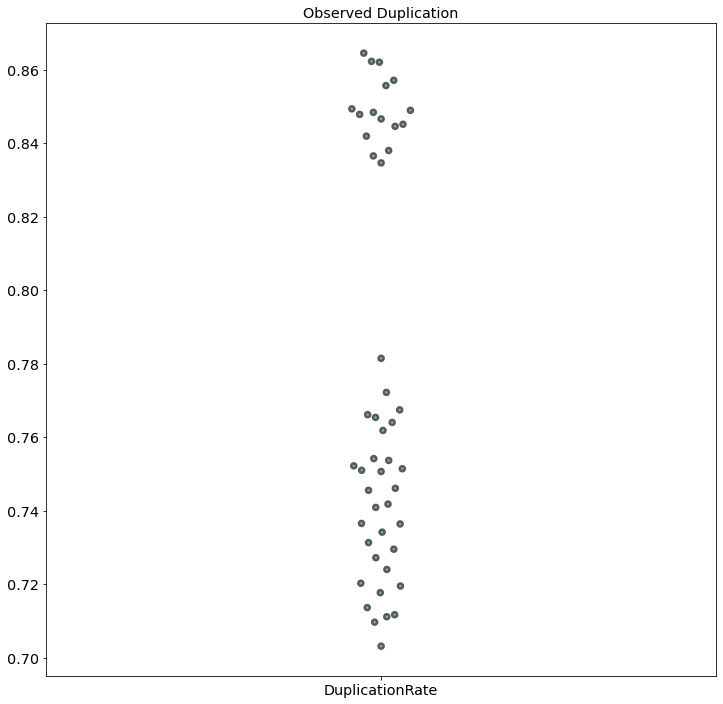

In [30]:
fig, ax = plt.subplots(figsize=(12,12))

plot_cats = ['DuplicationRate']
sns.swarmplot(data=flag_df[plot_cats], ax=ax, palette='Set2', linewidth=2.5)
ax.set_title('Observed Duplication')
#plt.savefig('duplication.png', dpi=200, bbox_inches='tight')
plt.show()